# Create new utility function

Import data.

In [1]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

load data


In [2]:
building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

Create inputs to the DrugEnv.

In [211]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner, Generator
from dgym.envs.oracle import DGLOracle, RDKitOracle, DockingOracle
from dgym.envs.utility import ClassicUtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    Generator(building_blocks, fingerprints)
)

# create evaluators
log_P_utility = ClassicUtilityFunction(
    RDKitOracle('MolLogP'),
    ideal=(1, 4),
    acceptable=(0, 5)
)

log_S_utility = ClassicUtilityFunction(
    DGLOracle('GCN_canonical_ESOL'),
    ideal=(-2, 0),
    acceptable=(-4, 0.5)
)

weight_utility = ClassicUtilityFunction(
    RDKitOracle('HeavyAtomMolWt'),
    ideal=(400, 500),
    acceptable=(300, 600)
)

# create utility function
def composite_utility_function(molecules):
    return log_P_utility(molecules) * log_S_utility(molecules)

First, set up the environment.

In [275]:
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from tqdm.notebook import tqdm

class Experiment:
    
    def __init__(self, drug_agent, drug_env):
        self.drug_agent = drug_agent
        self.drug_env = drug_env
    
    def run(self, num_trials):
        
        results = []
        for trial in range(num_trials):

            observations, info = drug_env.reset()

            pbar = tqdm(total = drug_env.budget)
            while True:
                action = drug_agent.act(observations)
                observations, _, terminated, truncated, _ = drug_env.step(action)
                pbar.n = len(drug_env.library.annotated)
                pbar.update()
                if terminated or truncated:
                    break

            result = {
                'trial': trial,
                'sequence': self.drug_agent.sequence,
                'epsilon': self.drug_agent.epsilon,
                'branch_factor': self.drug_agent.branch_factor
            }

            if terminated:
                cost = len(drug_env.library) - len(drug_env._library_0)
                result.update({'cost': cost, 'outcome': 1})

            if truncated:
                result.update({'outcome': 0})

            results.append(result)

        return results

In [280]:
drug_env = DrugEnv(
    library_designer,
    library = deck[[414]].update_annotations(),
    assays = utility_function.oracles,
    budget = 1_000,
    utility_function = composite_utility_function,
)

sequence = [
    {'name': 'ideate', 'parameters': {'temperature': 0.0, 'size': 10}},
    {'name': 'MolLogP'},
    {'name': 'HeavyAtomMolWt'},
]

drug_agent = SequentialDrugAgent(
    sequence = sequence,
    utility_function = composite_utility_function,
    epsilon = 0.0,
    branch_factor = 10
)

experiment = Experiment(drug_agent, drug_env)
result = experiment.run(1)

  0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: xlabel='design_cycle', ylabel='utility'>

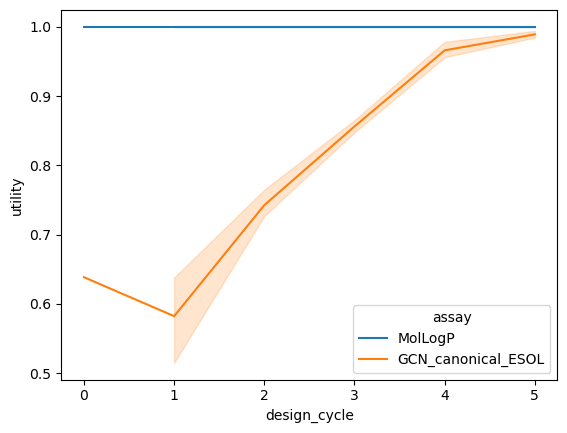

In [281]:
records = []
for utility_fn in [log_P_utility, log_S_utility]:
    scores = utility_fn(drug_env.library.annotated)
    for molecule, score in zip(drug_env.library.annotated, scores):
        records.append(
            {
                'design_cycle': molecule.design_cycle,
                'utility': score,
                'assay': utility_fn.oracle.name
            }
        )
        
sns.lineplot(
    pd.DataFrame(records),
    x='design_cycle',
    y='utility',
    hue='assay'
)

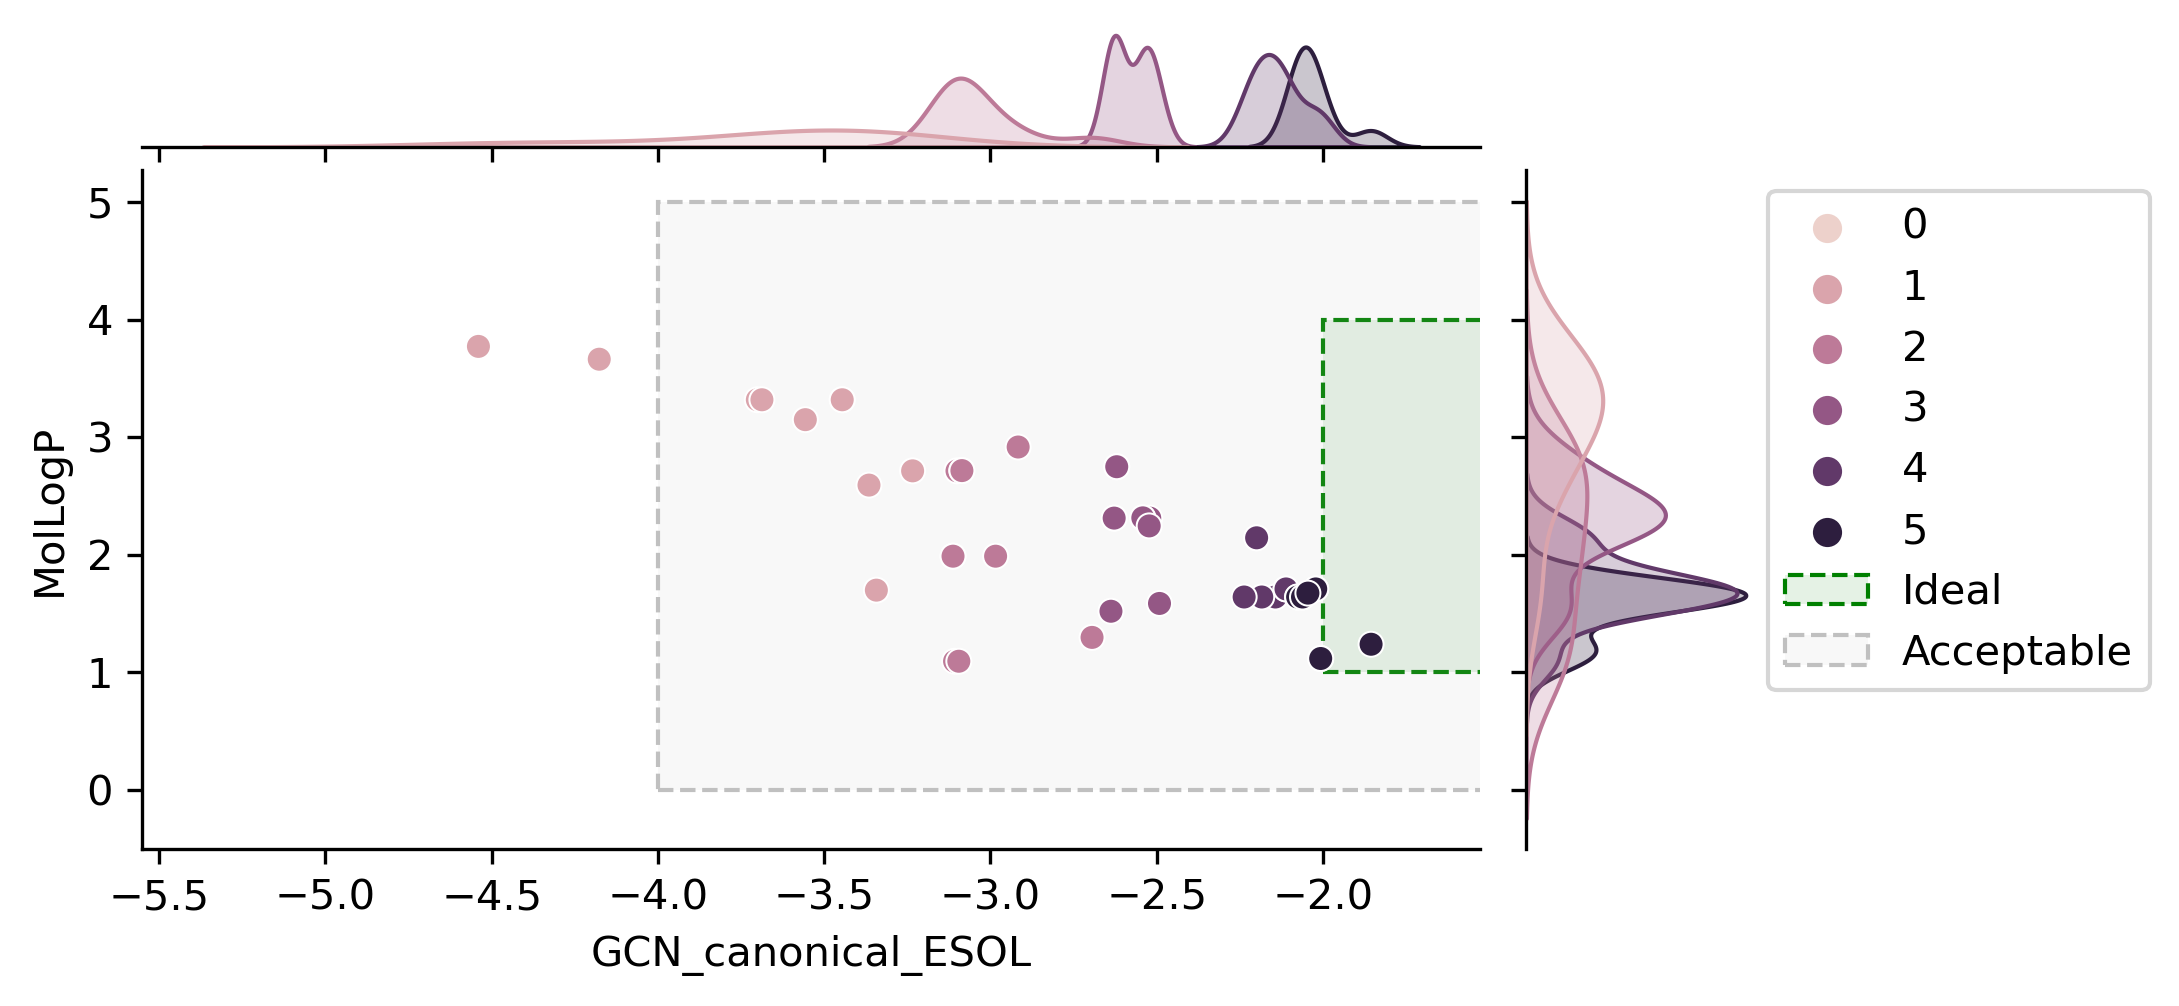

In [282]:
dg.plotting.plot(drug_env.library.annotated, [log_S_utility, log_P_utility])

Experimenting with Agent hyperparameters.

In [77]:
results = []
temperatures = [0.0, 0.2, 1.0]
for temperature in temperatures:
    print(temperature)
    
    drug_env = DrugEnv(
        library_designer,
        library = deck[20:22],
        assays = utility_function.oracles,
        budget = 500,
        utility_function = utility_function,
    )

    drug_agent = SequentialDrugAgent(
        sequence = sequence,
        utility_function = utility_function,
        epsilon = 0.5,
        branch_factor = 1
    )

    experiment = Experiment(drug_agent, drug_env)
    result = experiment.run(1)
    results.extend(result)

0.0


  0%|          | 0/500 [00:00<?, ?it/s]

0.2


  0%|          | 0/500 [00:00<?, ?it/s]

1.0


  0%|          | 0/500 [00:00<?, ?it/s]

In [78]:
def ecdf(costs):
    costs = np.array([c for c in costs])
    costs_sorted = np.sort(costs)
    probs = 1. * np.arange(1, len(costs) + 1) / len(costs)

    costs_sorted = np.concatenate([[0.0], costs_sorted])
    probs = np.concatenate([[0.0], probs])
    
    return costs_sorted, probs

In [79]:
import pandas as pd

data = pd.DataFrame()
for temperature in temperatures:
    raw_costs = [r['cost'] for r in df.to_dict('records') if r['temperature'] == temperature]
    cost, prob = ecdf(raw_costs)
    temp = pd.DataFrame({'cost': cost, 'prob': prob, 'temperature': temperature})
    data = pd.concat([data, temp])

NameError: name 'df' is not defined

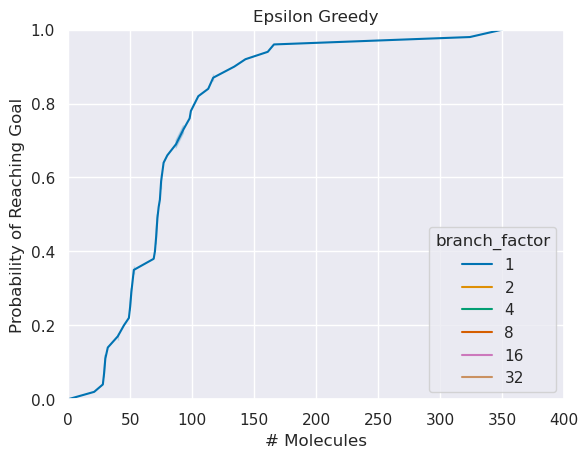

In [64]:
sns.set()
g = sns.lineplot(
    data,
    x='cost',
    y='prob',
    hue='epsilon',
    palette='colorblind'
)

g.set_title('Epsilon Greedy')
g.set_xlabel('# Molecules')
g.set_ylabel('Probability of Reaching Goal')
g.set_ylim([0, 1])
g.set_xlim(0, 500)

plt.gcf().set_dpi(150)
plt.show()

Draw lineage of best molecule.

In [65]:
from rdkit.Chem import Draw

utility = drug_agent.policy(observations)
index = int(np.argsort(utility)[-1])

mol = drug_env.library[index]
lineage = [mol]
while mol.inspiration:
    mol = mol.inspiration
    lineage.insert(0, mol)

assay_results = [assay(lineage) for assay in assays]
results = [
    utility_function.score(properties)
    for properties in zip(*assay_results)
]

display(Draw.MolsToGridImage(
    [m.mol for m in lineage],
    molsPerRow=8,
    maxMols=10_000
))

print('\t\t'.join(map(str, results)))
display(*zip(*assay_results))

NameError: name 'assays' is not defined

## Experimenting with a basic optimization loop.

In [568]:
mol = deck[649]
for _ in range(10):
    analogs = library_designer.design(
        molecule = mol,
        num_analogs = 10,
        temperature = 0.2
    )

    utility = utility_function(analogs)
    mol = analogs[np.argmax(utility).item()]
    
    print(np.mean(utility))
    print(utility)
    
    if np.mean(utility) > 0.8:
        break

0.5397510310764196
[0.49890077 0.57199806 0.69466764 0.59846324 0.62399361 0.36748483
 0.47118986 0.58870894 0.65977448 0.32232889]
0.43620898921254875
[0.29152273 0.53804131 0.41093391 0.25644882 0.26980297 0.57639092
 0.26024414 0.27396596 0.64558154 0.83915758]
0.6038911659871669
[0.66197159 0.55216628 0.47245089 0.74007082 0.70400564 0.5265
 0.5876894  0.53414101 0.54129493 0.7186211 ]
0.45719563878539393
[0.57177836 0.63720638 0.42451275 0.27850894 0.66178131 0.54546112
 0.47808598 0.29059224 0.39957283 0.2844565 ]
0.39004657261444114
[0.1344528  0.23124879 0.51515621 0.73354286 0.37682197 0.69252259
 0.53042138 0.32568662 0.3132071  0.04740542]
0.7226556127214199
[0.74839997 0.57448602 0.83398745 0.64956236 0.75433129 0.93759596
 0.37788251 0.66616935 0.78579122 0.89835   ]
0.6009625735370067
[0.94947791 0.53598118 0.50276512 0.65190107 0.24839555 0.90283161
 0.4214831  0.78108317 0.93759596 0.07811106]
0.6146980915800854
[0.66298455 0.55671334 0.44479933 0.78225815 0.59899294 0.

In [ ]:
# create evaluators
log_S_evaluator = ClassicEvaluator(ideal=(-2, 0), acceptable=(-4, 0.5))
log_P_evaluator = ClassicEvaluator(ideal=(1, 4), acceptable=(0, 5))

In [577]:
log_S_oracle([analogs[9]])

[-3.98738694190979]

In [578]:
utility_function([analogs[9]])

array([0.50315326])

In [572]:
log_P_oracle([analogs[9]])

[2.7784000000000004]